In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

import models.pd_decoders
import models.generators
import models.pi_models
import models.point_clouds_encoders
import models.data_to_pd_models
import models.image_encoders
import train_models

from torch.nn import MSELoss, CrossEntropyLoss
from persim import PersistenceImager
from gudhi.representations.vector_methods import PersistenceImage as PersistenceImageGudhi
import wandb
import random

from get_datasets import get_loaders_by_name
import utils.metrics
from utils.loss_functions import ChamferLoss, HungarianLoss, SlicedWasserstein

from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau, SequentialLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda', index=0)

In [4]:
dataset_name = 'Orbit5k'
batch_size = 64
dataloader_train, dataloader_test, num_classes, n_max, sigma, im_range = get_loaders_by_name(dataset_name,
                                                                                            batch_size,
                                                                                            data_type='pc')

In [17]:
sigma, im_range

(0.021685884113527586, [0.0, 0.46631506085395813, 0.0, 0.40915297716856003])

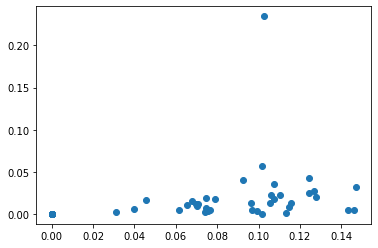

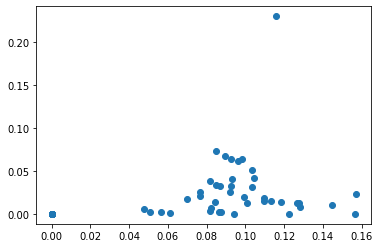

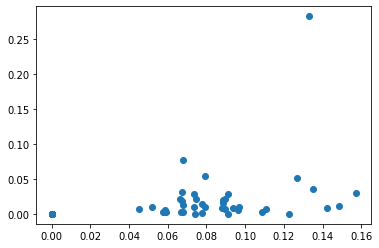

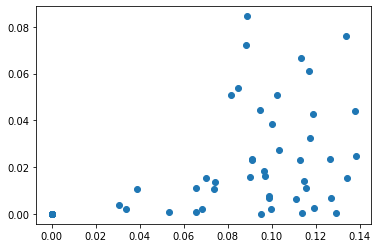

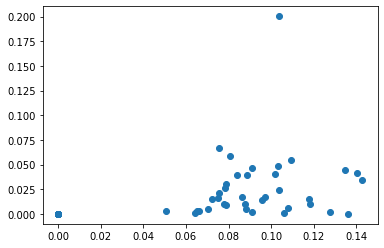

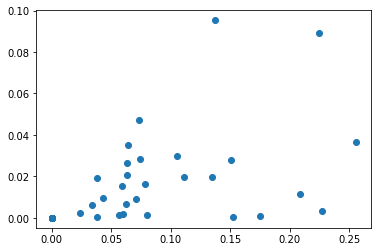

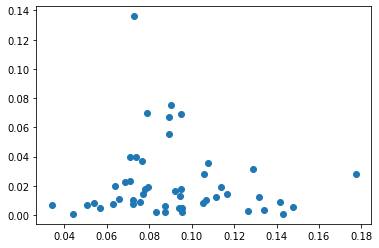

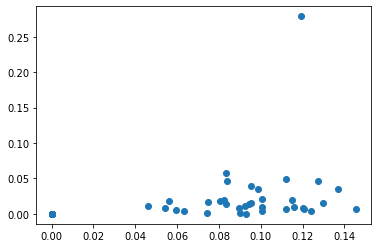

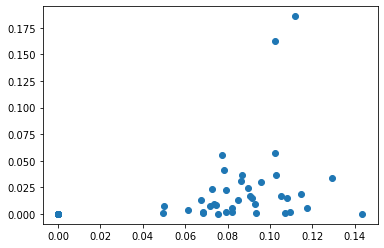

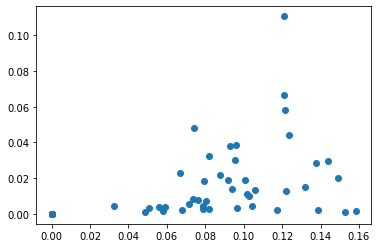

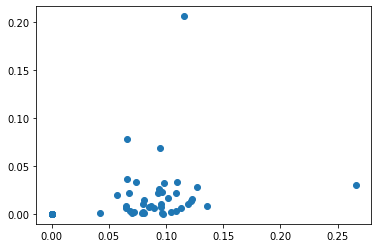

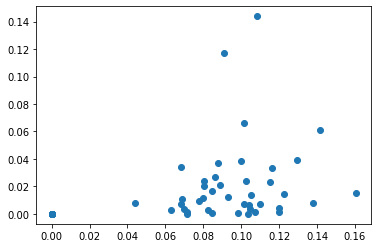

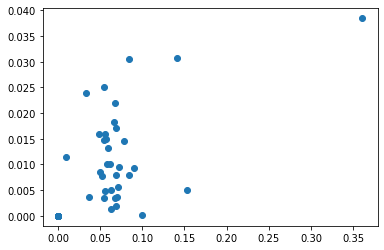

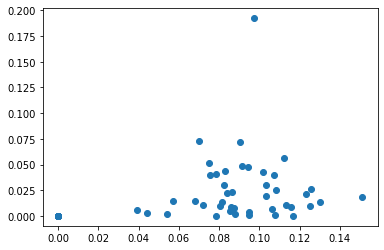

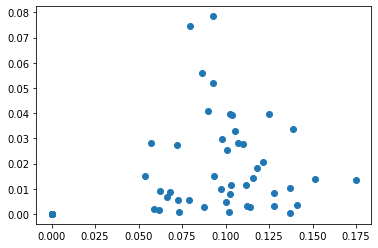

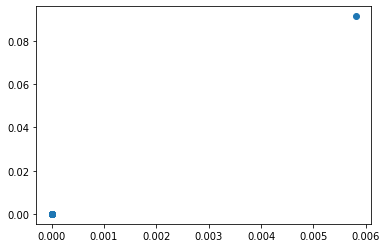

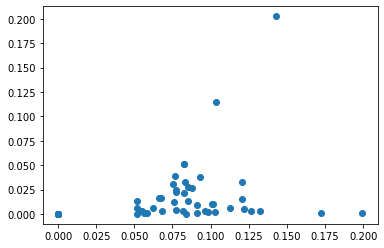

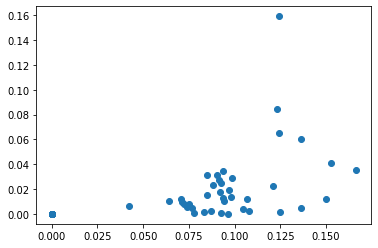

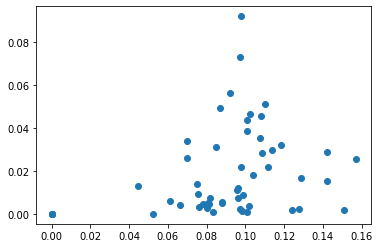

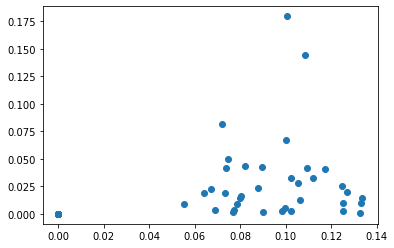

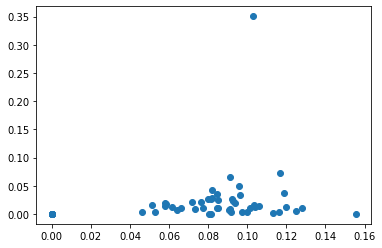

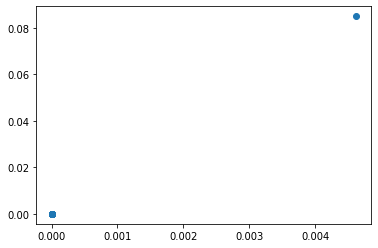

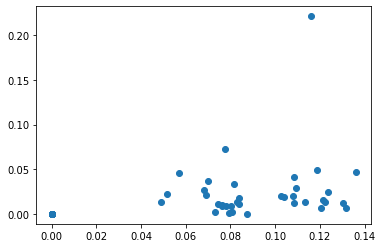

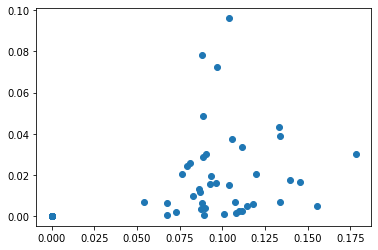

In [5]:
for src_pd, _, _, _, PI in dataloader_test:
    plt.scatter(src_pd[0,:,0], src_pd[0,:,1])
    #plt.imshow(PI[0].reshape(50,50))
    plt.show()

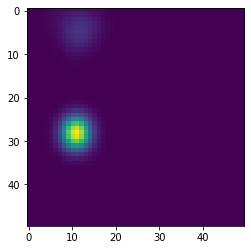

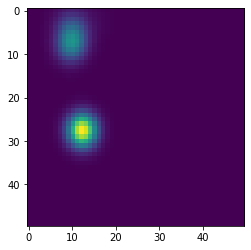

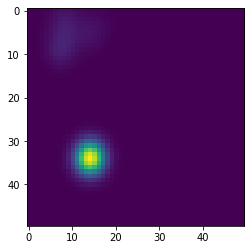

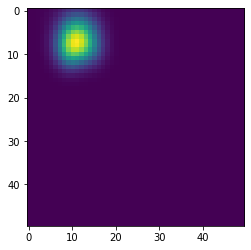

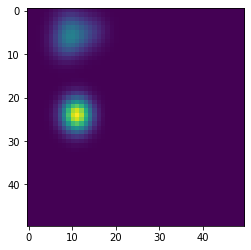

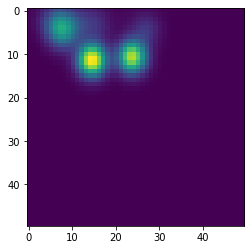

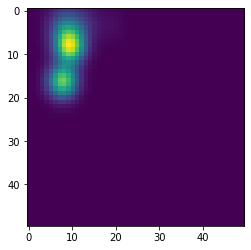

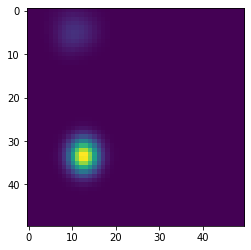

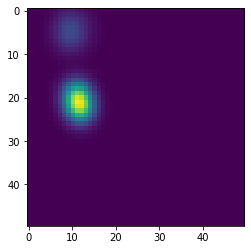

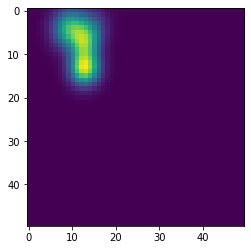

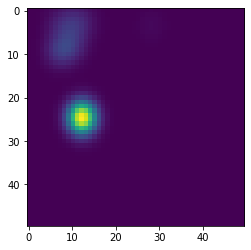

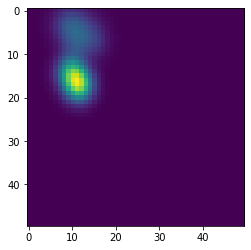

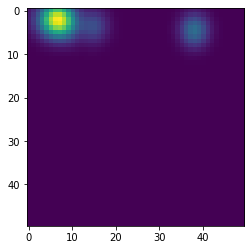

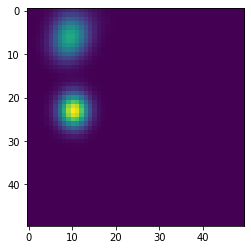

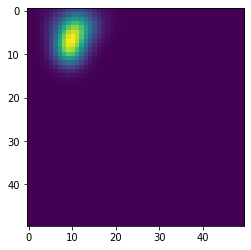

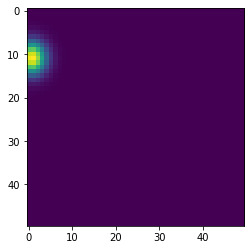

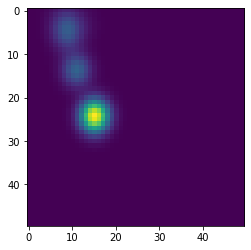

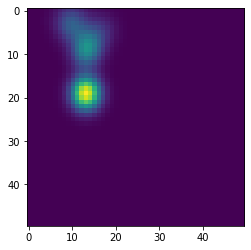

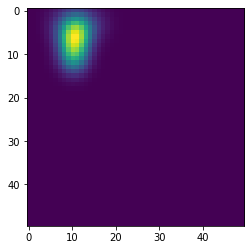

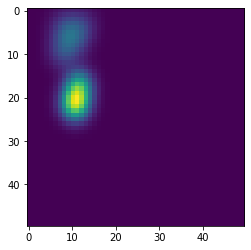

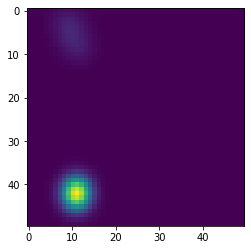

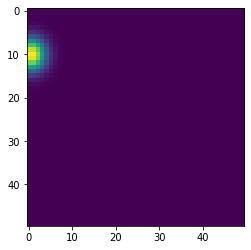

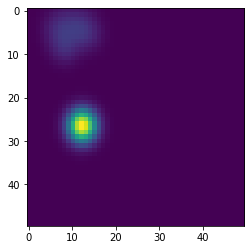

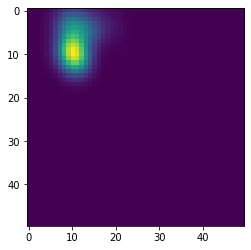

In [27]:
for src_pd, _, _, _, PI in dataloader_test:
    
    src_pd[...,1]+=src_pd[...,0]
    #ll[...,1]+=ll[...,0]
    pimgr = PersistenceImageGudhi(bandwidth=sigma, resolution=[50, 50], 
                                  weight=lambda x: (x[1])**2, im_range=im_range)
    pimgs = pimgr.fit_transform(src_pd)
    for i, img in enumerate(pimgs):
        img /= img.max()
        pimgs[i] = img
    plt.imshow(pimgs[0].reshape(50,50))
    plt.show()

In [ ]:
pimgr.fit_transform()

In [62]:
kek = {}

for i in range(3):
    if i == 0:
        kek['lol'] = []
        kek['sis'] = []
    kek['lol'].append(i + 1)
    kek['sis'].append(i*2)

In [64]:
torch.save(kek, './results/xdd.pt')

In [65]:
aa = torch.load('./results/xdd.pt')
aa

{'lol': [1, 2, 3], 'sis': [0, 2, 4]}

In [2]:
dataset_name = 'Obayashi-Hiraoka'
batch_size = 64
dataloader_train, dataloader_test, num_classes, n_max, sigma, im_range = get_loaders_by_name(dataset_name,
                                                                                            batch_size,
                                                                                            data_type='image')

In [5]:
in_channels=1
latent_dim = 1024
size_predictor = models.image_encoders.SimpleCNNEncoder(in_channels=1, n_out_enc=1).to(device)
simple_cnn = models.image_encoders.SimpleCNNEncoder(in_channels=in_channels, 
                                                    n_out_enc=latent_dim).to(device)

top_n = models.generators.TopNGenerator(set_channels=2,
                                        cosine_channels=32, 
                                        max_n=n_max + 20, 
                                        latent_dim=latent_dim).to(device)

mlp_gen = models.generators.MLPGenerator(set_channels=2,
                                        max_n=n_max+20,
                                        mlp_gen_hidden=512,
                                        n_layers=2,
                                        latent_dim=latent_dim).to(device)

encoders = [(simple_cnn, 'SimpleCNN')]
generators = [(mlp_gen, 'MLPGen')]

for encoder, encoder_name in encoders:
    for generator, generator_name in generators:

        decoder = models.pd_decoders.TransformerDecoder(n_in=2,
                                                        latent_dim=latent_dim,
                                                        fc_dim=512, 
                                                        num_heads=4,
                                                        num_layers=3, 
                                                        n_out=2,
                                                        generator=generator,
                                                        n_out_lin=256, 
                                                        n_hidden=512, 
                                                        num_layers_lin=2,
                                                        dropout = 0.1,
                                                        use_conv=False).to(device)

        model = models.data_to_pd_models.OneShotPd(encoder, 
                                                   decoder, 
                                                   size_predictor=size_predictor,
                                                   n_max=n_max).to(device)
        model.load_state_dict(
                torch.load('./pretrained_models/final_full_model_SimpleCNN_MLPGen_Obayashi-Hiraoka_run_0.pt')
            )
        model = model.to(device)
        model.eval()

In [10]:
model_pred = models.point_clouds_encoders.CustomPersformer(n_in = 2, embed_dim = 128, fc_dim = 256, num_heads = 8, 
                                  num_layers = 5, n_out_enc = num_classes, dropout = 0.0, 
                                  reduction = 'mean').to(device)

In [11]:
model_pred.load_state_dict(torch.load('./pretrained_models/model_classifier_pred_0.7580_SimpleCNN_MLPGen_Obayashi-Hiraoka_classificator.pt'))

<All keys matched successfully>

In [14]:
model_real = models.point_clouds_encoders.CustomPersformer(n_in = 2, embed_dim = 128, fc_dim = 256, num_heads = 8, 
                                  num_layers = 5, n_out_enc = num_classes, dropout = 0.0, 
                                  reduction = 'mean').to(device)

In [15]:
model_real.load_state_dict(torch.load('./pretrained_models/model_classifier_real_0.8747_SimpleCNN_MLPGen_Obayashi-Hiraoka_classificator.pt'))

<All keys matched successfully>

In [17]:
utils.metrics.calculate_accuracy(model, model_real, dataloader_test, True)

0.8746666312217712

In [13]:
utils.metrics.calculate_accuracy(model, model_pred, dataloader_test, False)

0.7580000162124634